# Exploratory Data Analysis

<hr />

## Import libraries

In [1]:
import pandas as pd
import openpyxl
from matplotlib import pyplot as plt
import spacy
import seaborn as sns
import altair as alt
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

<hr />



## Read in excel file to pandas

In [2]:
api_df = pd.read_excel(
    "../data/raw/RiskClassification_Data_Endpoints_V2_Shared.xlsx",
    "Core_Endpoint"
)
country_df = pd.read_excel(
    "../data/raw/nri_2021_dataset.xlsx", 
    "NRI 2021 - results", usecols="B:C", skiprows=1
)
api_df.head()
# country_df.head()

api_endpoint_id  api_id  api_vendor_id                   api  request_id  \
0             2513    1117            411             Tenor API        7629   
1             2578    1148            440          ANZ Products        8698   
2             2575    1147            439         NAB Open APIs        8542   
3             2516    1119            413        Translate Text        7733   
4             2416    1050            365  Google Custom Search       24061   

  method             category  \
0    get         News & Media   
1    get    Finance & Banking   
2    get    Finance & Banking   
3    get    AI & Data Science   
4    get  Software & Services   

                                          parameters usage_base  \
0                                   {"q": "Running"}       free   
1                                                 {}       free   
2                                         {"v": "1"}       free   
3  {"lang": "en-zh", "text": "GNE is a good schoo...       free   
4                       {"q": "Dehri, Bihar, India"}       free   

                                     sample_response  \
0  {\n  "weburl": "https://tenor.com/search/runni...   
1  {"data":{"products":[{"additionalInformation":...   
2  <HTML><HEAD>\n<TITLE>Access Denied</TITLE>\n</...   
3  {"code":200,"lang":"en-zh","text":["ç½‘å…³ç½‘å...   
4  {\n  "kind": "customsearch#search",\n  "url": ...   

                                              tagset authentication  \
0                                                NaN            NaN   
1  links,eligibilityUri,brand,next,overviewUri,da...         header   
2                                                NaN         header   
3            lang,code,text,text,text,text,text,text          query   
4  template,snippet,safe,type,url,items,cacheId,h...          query   

  security_test_category  security_test_result (FALSE=Passed; TRUE=Failed)  \
0                    NaN                                               NaN   
1                    NaN                                               NaN   
2                    NaN                                               NaN   
3                    NaN                                               NaN   
4                    NaN                                               NaN   

  server_location                hosting_isp  server_name  \
0             NaN                        NaN          NaN   
1       Singapore              Incapsula Inc  istio-envoy   
2   United States  Akamai Technologies, Inc.  AkamaiGHost   
3          Russia  Yandex enterprise network  nginx/1.6.2   
4   United States                 Google LLC          ESF   

                                   response_metadata   hosting city  
0                                                NaN            NaN  
1  {"via": "kong/0.36-2-enterprise-edition", "x-v...      Singapore  
2  {"Date": "Wed, 18 Mar 2020 07:27:41 GMT", "Ser...         Newark  
3  {"Date": "Mon, 23 Dec 2019 23:10:35 GMT", "Ser...         Moscow  
4  {"Date": "Thu, 07 Oct 2021 19:14:31 GMT", "Var...  Mountain View

<hr />



## Pre-processing

In [3]:
# Rename the column
api_df.rename(
    columns={
        "security_test_result (FALSE=Passed; TRUE=Failed)": "security_test_result",
        "risk_label_Baljeet": "risk_label",
    },
    inplace=True,
)
# Change Server_name as Boolean
api_df["Is_server_name"] = (
    (api_df["server_name"] != "Unavailable/Obscured") & (api_df["server_name"] != "")
).astype("bool")
# Update Synonyms
api_df.loc[
    api_df["hosting_isp"] == "Amazon Technologies Inc.", "hosting_isp"
] = "Amazon.com, Inc."
# Combine the Security Test Category and the result
api_df["security_test_result"] = api_df["security_test_result"].astype("bool")
api_df["security_test_result_combined"] = (
    api_df["security_test_category"] + ":" + api_df["security_test_result"].astype(str)
)
# Merge country_metric data with input data
df = api_df.merge(country_df, left_on="server_location", right_on="Country", how="left")
# Remove duplicates
df = df.drop_duplicates()
df.head()

api_endpoint_id  api_id  api_vendor_id                   api  request_id  \
0             2513    1117            411             Tenor API        7629   
1             2578    1148            440          ANZ Products        8698   
2             2575    1147            439         NAB Open APIs        8542   
3             2516    1119            413        Translate Text        7733   
4             2416    1050            365  Google Custom Search       24061   

  method             category  \
0    get         News & Media   
1    get    Finance & Banking   
2    get    Finance & Banking   
3    get    AI & Data Science   
4    get  Software & Services   

                                          parameters usage_base  \
0                                   {"q": "Running"}       free   
1                                                 {}       free   
2                                         {"v": "1"}       free   
3  {"lang": "en-zh", "text": "GNE is a good schoo...       free   
4                       {"q": "Dehri, Bihar, India"}       free   

                                     sample_response  ...  \
0  {\n  "weburl": "https://tenor.com/search/runni...  ...   
1  {"data":{"products":[{"additionalInformation":...  ...   
2  <HTML><HEAD>\n<TITLE>Access Denied</TITLE>\n</...  ...   
3  {"code":200,"lang":"en-zh","text":["ç½‘å…³ç½‘å...  ...   
4  {\n  "kind": "customsearch#search",\n  "url": ...  ...   

  security_test_result server_location                hosting_isp  \
0                 True             NaN                        NaN   
1                 True       Singapore              Incapsula Inc   
2                 True   United States  Akamai Technologies, Inc.   
3                 True          Russia  Yandex enterprise network   
4                 True   United States                 Google LLC   

   server_name                                  response_metadata  \
0          NaN                                                NaN   
1  istio-envoy  {"via": "kong/0.36-2-enterprise-edition", "x-v...   
2  AkamaiGHost  {"Date": "Wed, 18 Mar 2020 07:27:41 GMT", "Ser...   
3  nginx/1.6.2  {"Date": "Mon, 23 Dec 2019 23:10:35 GMT", "Ser...   
4          ESF  {"Date": "Thu, 07 Oct 2021 19:14:31 GMT", "Var...   

    hosting city Is_server_name security_test_result_combined        Country  \
0            NaN           True                           NaN            NaN   
1      Singapore           True                           NaN      Singapore   
2         Newark           True                           NaN  United States   
3         Moscow           True                           NaN         Russia   
4  Mountain View           True                           NaN  United States   

   NRI score  
0        NaN  
1  80.014421  
2  81.089820  
3  57.744039  
4  81.089820  

[5 rows x 23 columns]

<hr />



## Distribution of target variable 

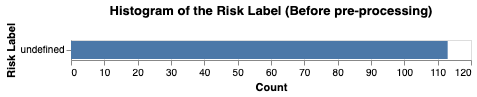

In [4]:
alt.Chart(df, title="Histogram of the Risk Label (Before pre-processing)").mark_bar().encode(
    y=alt.Y("risk_label", type="nominal", title="Risk Label"),
    x=alt.X("count()", title="Count")
)

> Skewness problem was found in particular labels such as "High" and "Low" compared to other labels.

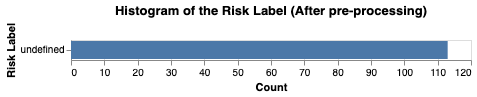

In [5]:
alt.Chart(df, title="Histogram of the Risk Label (After pre-processing)").mark_bar().encode(
    y=alt.Y("risk_label", type="nominal", title="Risk Label"),
    x=alt.X("count()", title="Count")
)

> After we wrangled the data, the data was less skewed than before. However, it came to another problem. There was a insufficient data problem in the risk labels except the "Low" label, which may not be representative enough to reflect the ground truth. 

<hr />

## Distribution of all Numerical Features

In [6]:
numerical_features = [
    'NRI score'
]

In [7]:
df[numerical_features].describe()

NRI score
count  103.000000
mean    76.540403
std      6.922161
min     49.744597
25%     76.479613
50%     76.479613
75%     81.089820
max     81.089820

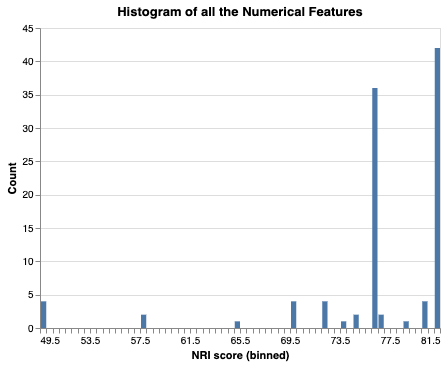

In [8]:
alt.Chart(df, title="Histogram of all the Numerical Features").mark_bar().encode(
    x=alt.X(alt.repeat(), bin=alt.Bin(maxbins=100)), y=alt.Y("count()", title="Count")
).repeat(numerical_features, columns=2)

## Histogram of all Categorical Features

In [9]:
categorical_features = [
    "category",
    "usage_base",
    "authentication",
    "security_test_result_combined",
    "Country",
    "hosting_isp",
    "hosting city",
]

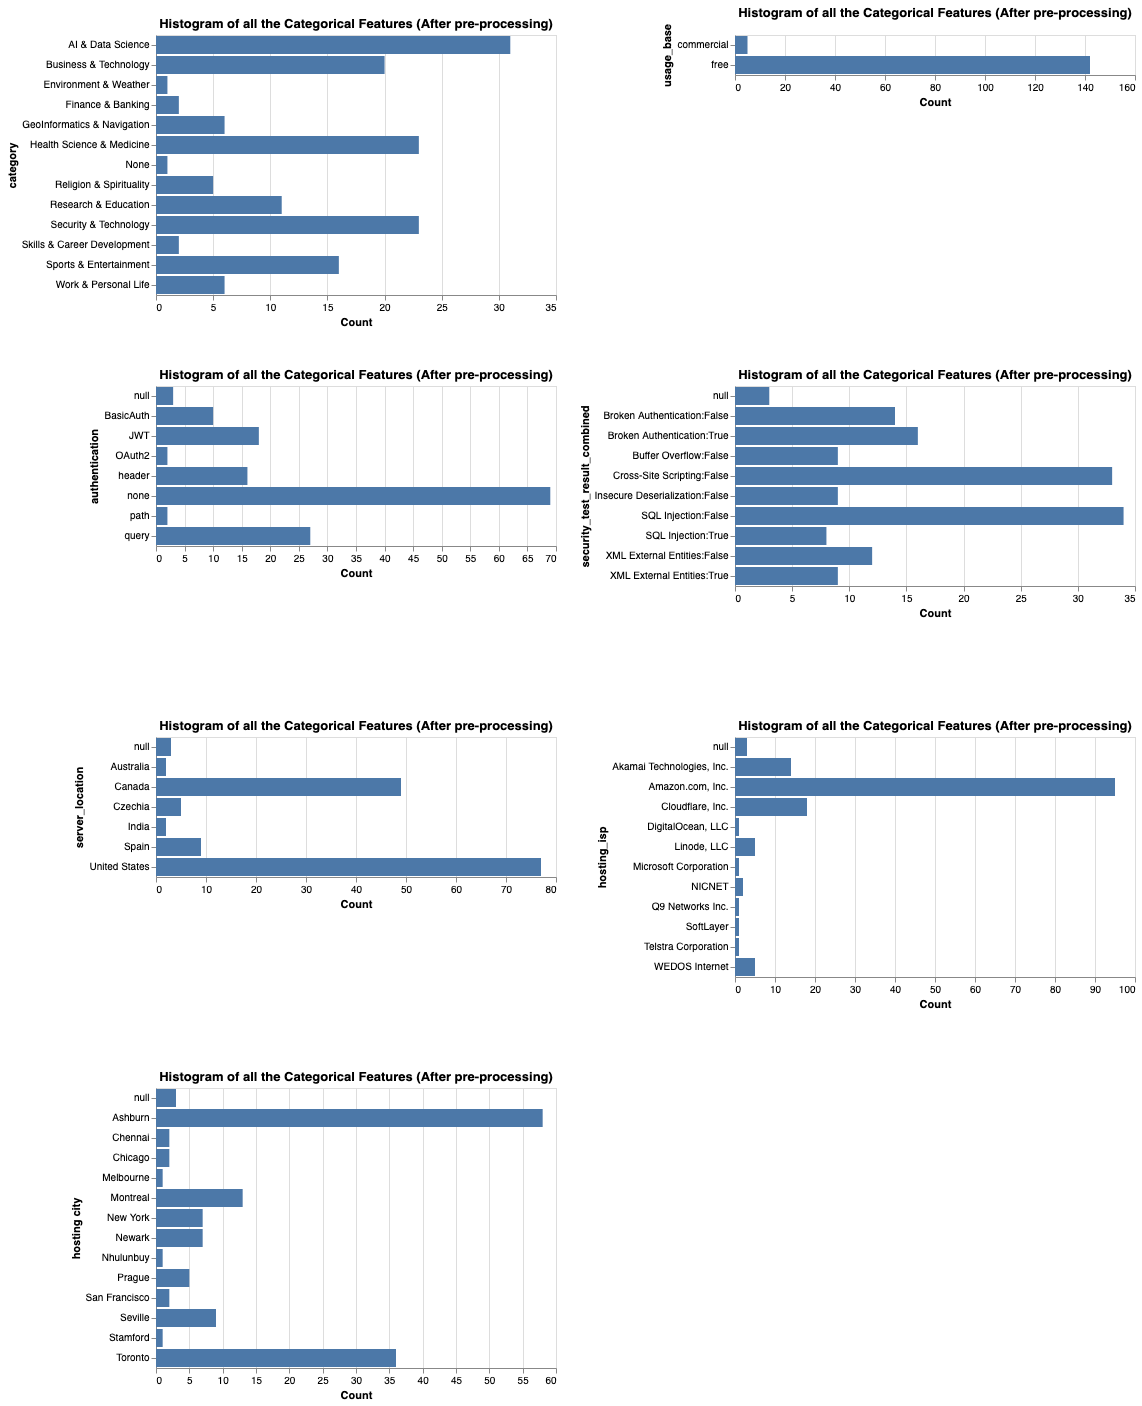

In [27]:
alt.Chart(
    df, title="Histogram of all the Categorical Features (After pre-processing)"
).mark_bar().encode(
    y=alt.Y(alt.repeat(), type="nominal"), x=alt.X("count()", title="Count")
).repeat(
    categorical_features, columns=2
)

<hr />



## Distribution of Risk Label by Unique API Endpoint

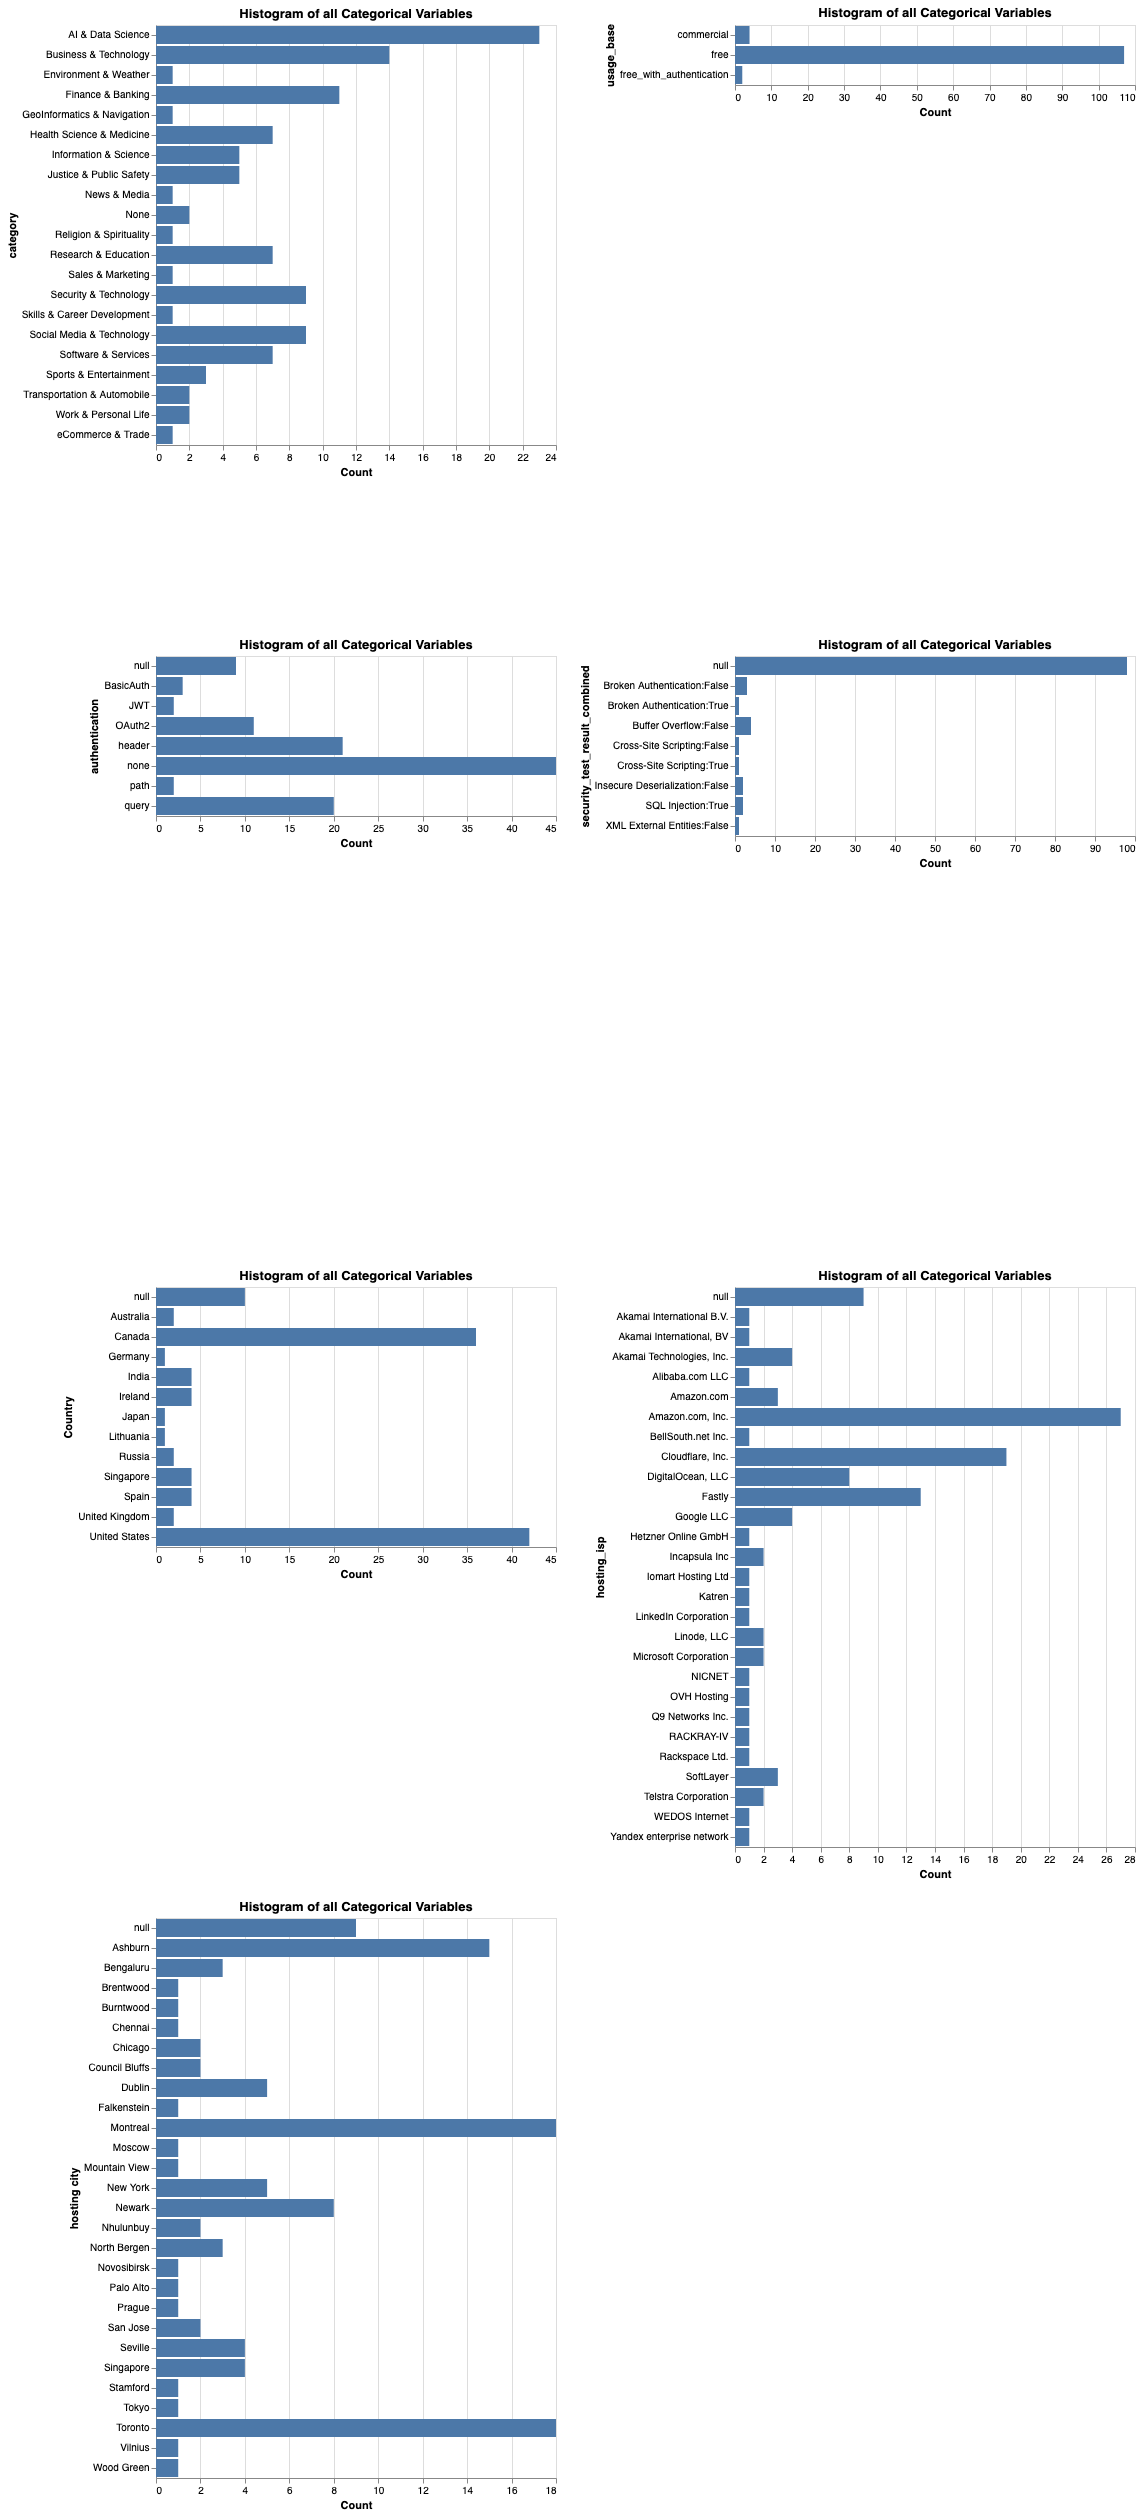

In [10]:
alt.Chart(df, title="Histogram of all Categorical Variables").mark_bar().encode(
    y=alt.Y(alt.repeat()), x=alt.X("count()", title="Count")
).repeat(categorical_features, columns=2)

In [11]:
# plt.figure(figsize=(14, 10))
# sns.countplot(y="api_endpoint_id", data=api_df, hue="risk_label").set(
#     xlabel="Count", ylabel="API Endpoint Id"
# )
# plt.title(
#     "Histogram of API Endpoint Id versus Risk Label (Before Pre-processing)",
#     weight="bold",
# )
# plt.legend(title="Risk Label")

> Before pre-processing, the risk labels were heavily biased towards specific API endpoints (e.g. 90% of high risk labels fell into 2812).

In [12]:
# df.groupby(['api_endpoint_id', 'risk_label']).size()

In [13]:
# plt.figure(figsize=(14, 10))
# sns.countplot(y="api_endpoint_id", data=api_df_preprocessed, hue="risk_label").set(
#     xlabel="Count",
#     ylabel="API Endpoint Id",
# )
# plt.title('Histogram of API Endpoint Id versus Risk Label (After Pre-processing)', weight='bold')
# plt.legend(title="Risk Label")

> After the pre-processing step, the distribution of API endpoint Id versus Risk label was less skewed.

<hr />

## Distribution of Categorical Variables by Risk Labels

In [16]:
# alt.Chart(df, title="Histogram of the Category by Risk Labels (After pre-processing)").mark_bar().encode(
#     y=alt.Y("category", type="nominal", title="Category"),
#     x=alt.X("count()", title="Count"),
#     color=alt.Color("risk_label", title="Risk Label")
# )

> High Risk label was too skewed towards AI & Data Science. Meanwhile, sample sizes across other categories were quite small.

In [17]:
# alt.Chart(df, title="Histogram of the Usage Base by Risk Labels (After pre-processing)").mark_bar().encode(
#     y=alt.Y("usage_base", type="nominal", title="Usage Base"),
#     x=alt.X("count()", title="Count"),
#     color=alt.Color("risk_label", title="Risk Label")
# )

> The problem here was the data points from commercial APIs were considerably small when compared to free.

In [19]:
# alt.Chart(df, title="Histogram of API Vendor by Risk Labels (After pre-processing)").mark_bar().encode(
#     y=alt.Y("api_vendor", type="nominal", title="API Vendor"),
#     x=alt.X("count()", title="Count"),
#     color=alt.Color("risk_label", title="Risk Label")
# )

> The problem here was the data points  were considerably small. We cannot draw a statistical conclusion that the certain level of risk labels is associated with certain API vendor (e.g. High Risk <-> TeejLab)

In [21]:
# alt.Chart(df, title="Histogram of Server Location by Risk Labels (After pre-processing)").mark_bar().encode(
#     y=alt.Y("server_location", type="nominal", title="Server Location"),
#     x=alt.X("count()", title="Count"),
#     color=alt.Color("risk_label", title="Risk Label")
# )

> Most of the high risk labels were skewed towards Canada, which may not reflect the ground truth.

In [23]:
# alt.Chart(df, title="Histogram of Hosting ISP by Risk Labels (After pre-processing)").mark_bar().encode(
#     y=alt.Y("hosting_isp", type="nominal", title="Hosting ISP"),
#     x=alt.X("count()", title="Count"),
#     color=alt.Color("risk_label", title="Risk Label")
# )

> Most of the high risk labels were skewed towards Amazon, which may not reflect the ground truth.

In [25]:
# alt.Chart(df, title="Histogram of Hosting City by Risk Labels (After pre-processing)").mark_bar().encode(
#     y=alt.Y("hosting city", type="nominal", title="Hosting City"),
#     x=alt.X("count()", title="Count"),
#     color=alt.Color("risk_label", title="Risk Label")
# )

> Most of the high risk labels were skewed towards Toronto, which may not reflect the ground truth.

In [27]:
# alt.Chart(df, title="Histogram of Server Name by Risk Labels (After pre-processing)").mark_bar().encode(
#     y=alt.Y("server_name", type="nominal", title="Server Name"),
#     x=alt.X("count()", title="Count"),
#     color=alt.Color("risk_label", title="Risk Label")
# )

<hr />



## Security Test Category versus Risk Label

In [ ]:
alt.Chart(df).mark_bar().encode(
    x=alt.X("security_test_category", title="Security Test Category", type="nominal"),
    color=alt.Color("security_test_result", title="IsResultFailed"),
    y=alt.Y("count()", title="Count"),
).facet(
    facet=alt.Facet("risk_label", title=None),
    title="Histogram of Security Test Category versus Risk Label (Before preprocessing)",
)

> Before pre-processing, the high risk labels were heavily biased (e.g. almost 99% of high risk labels fell into failed SQL Injection test).

In [30]:
# alt.Chart(df).mark_bar().encode(
#     x=alt.X("security_test_category", title="Security Test Category", type="nominal"),
#     color=alt.Color("security_test_result", title="IsTestFailed"),
#     y=alt.Y("count()", title="Count"),
# ).facet(
#     facet=alt.Facet("risk_label", title=None),
#     title="Histogram of Security Test Category versus Risk Label",
# )

> After pre-processing, the data was less skewed but the sample size was not big enough to dig out the patterns of high and medium risk label.

<hr />



## Authentication versus Risk Label

In [33]:
# alt.Chart(df).mark_bar().encode(
#     x=alt.X("authentication", type="nominal"),
#     y=alt.Y("count()", title="Count")
# ).facet(
#     facet=alt.Facet("risk_label", title=None),
#     title="Histogram of Authentication versus Risk Label (After preprocessing)",
# )

> Graphically speaking, 'None' authentication was the only feature assoicated with high risk label. But since there were also high proportion of None authentication on other labels and the samples size was not large enough, more data is needed to make such statistical hypothesis.

<hr />

## Server name versus Risk Label

In [34]:
# alt.Chart(df).mark_bar().encode(
#     y=alt.Y("Is_server_name", title="Server Name", type="nominal"),
#     x=alt.X("count()", title="Count")
# ).facet(
#     facet=alt.Facet("risk_label", title=None),
#     columns=1,
#     title="Histogram of Exposure of Server name versus Risk Label (After preprocessing)",
# )

> We cannot make a statistical conclusion that leaking server name information is assoicated with the risk label. More data is required for further analysis.

<hr />



## Correlation between categorical variables

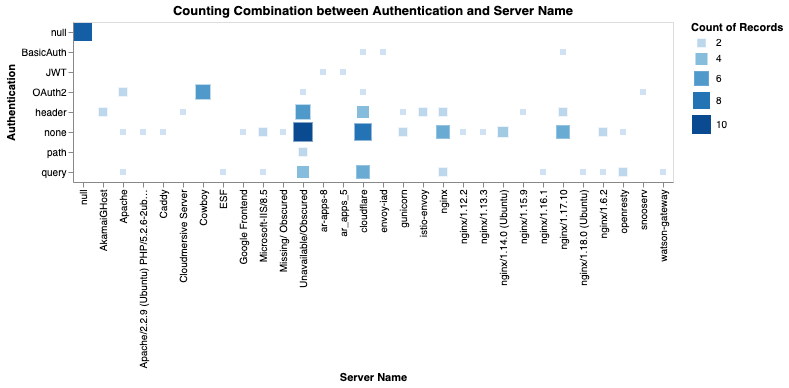

In [35]:
alt.Chart(
    df,
    title="Counting Combination between Authentication and Server Name",
).mark_square().encode(
    x=alt.X("server_name", title="Server Name"),
    y=alt.Y("authentication", title="Authentication"),
    color="count()",
    size="count()",
)

> The authentication method "None" was highly correlated to the Server "Unavailable/Obscured". Most of the "None" Authentication also lied on the servers "nginx" and "cloudflare".

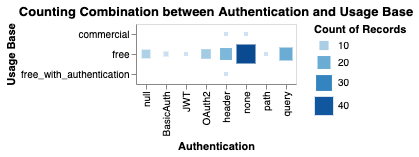

In [36]:
alt.Chart(
    df,
    title="Counting Combination between Authentication and Usage Base",
).mark_square().encode(
    x=alt.X("authentication", title="Authentication"), y=alt.Y("usage_base", title="Usage Base"), color="count()", size="count()"
)

> Free API was highly correlated with 'None' Authentication.

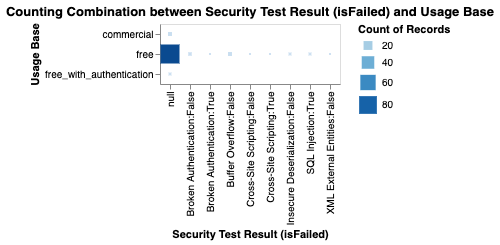

In [37]:
alt.Chart(
    df,
    title="Counting Combination between Security Test Result (isFailed) and Usage Base",
).mark_square().encode(
    x=alt.X("security_test_result_combined", title="Security Test Result (isFailed)"),
    y=alt.Y("usage_base", title="Usage Base"),
    color="count()",
    size="count()",
)

> Passed Result of Cross Site Scripting and SQL Injection were highly correlated with Free API.

## Correlation between numerical and categorical variables

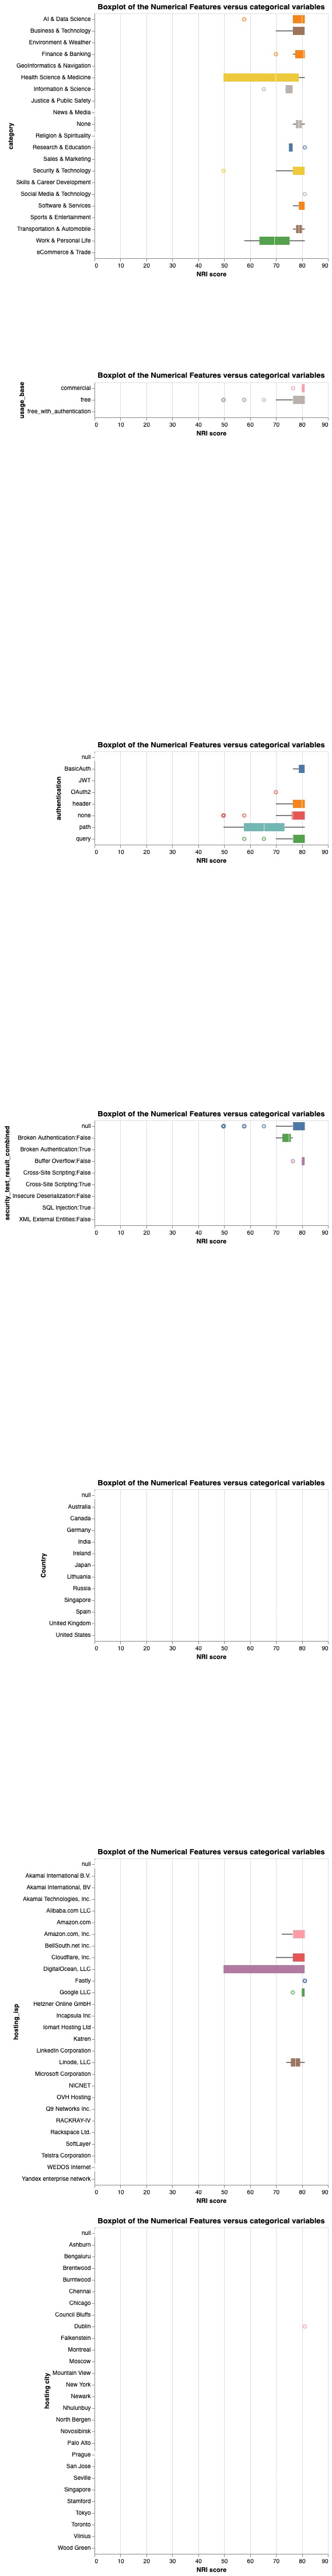

In [38]:
alt.Chart(df, title="Boxplot of the Numerical Features versus categorical variables").mark_boxplot().encode(
    x=alt.X('NRI score', type='quantitative'),
    y=alt.Y(alt.repeat('row')),
    color=alt.Color(alt.repeat('row'), legend=None)
).repeat(
    row=categorical_features
)

## 